In [2]:
import pandas as pd
import numpy as np
from shapely.geometry import Point
import geopandas as gpd
from collections import Counter

## Data Importation

I modified the data files, to get the localisation in metric, so I can do operation on them

This file regroup the results of the study, were people give "grades" regarding to 3 main factors: clean (between 1 and 4, 1 is the worst), noise and smell (0 or 1, 1 is the worst).

In [3]:
wellbeing=pd.read_csv('TARGET-communities-extract-wellbeingTARGET-communities-extract-wellbeing-meters.csv')

In [360]:
wellbeing.head()

,Unnamed: 0,Unnamed: 1,clean,smell,noise,town,district,longitude,latitude,transformed_longitude,transformed_latitude
0,1,万寿社区居委会,3,0.0,0.0,盈浦街道,青浦区,121.104287,31.155882,-2.822208e+06,4.677636e+06
1,2,万泰花园第一居委会,3,1.0,0.0,七宝镇,闵行区,121.351529,31.144327,-2.842711e+06,4.665980e+06
2,3,万科阳光苑居委会,2,0.0,0.0,吴泾镇,闵行区,121.468520,31.042285,-2.855282e+06,4.665149e+06
3,4,万豪居委会,3,0.0,0.0,长征镇,普陀区,121.367237,31.240725,-2.841109e+06,4.660474e+06
4,5,万里名轩社区居委会,2,NaN,0.0,万里街道,普陀区,121.403601,31.269155,-2.843214e+06,4.657274e+06


This file gives us the POI (Point Of Interest in Shanghai) such as restaurant, shopping center etc.

In [4]:
poi=pd.read_csv('utseus-cendus-poi-meters.csv')

This file gives us information on the localisation and speed of the taxis in Shnaghai, for 1 day

In [5]:
taxi=pd.read_csv('utseus-shanghai-taxi-speed-position-meters.csv')

Here we have the informations about the subway stations

In [6]:
Subway=pd.read_csv('subway-meters.csv')

## Correspondance between the people's rating and their area

The "grades" are not in a 'number' format, so we replace them as float, so we can do operations on them

In [4]:
wellbeing.replace('', np.nan, inplace=True)

wellbeing['clean'] = wellbeing['clean'].apply(lambda x: float(x))
wellbeing['smell'] = wellbeing['smell'].apply(lambda x: float(x))
wellbeing['noise'] = wellbeing['noise'].apply(lambda x: float(x))
wellbeing['longitude'] = wellbeing['longitude'].apply(lambda x: float(x))
wellbeing['latitude'] = wellbeing['latitude'].apply(lambda x: float(x))

We then transform the datas about longitude and latitude into points, so we can place them in the different neighborhoods

In [5]:
geometry = [Point(xy) for xy in zip(wellbeing['transformed_longitude'], wellbeing['transformed_latitude'])]

In [6]:
wellbeing['geometry'] = geometry

In [365]:
wellbeing.head()

,Unnamed: 0,Unnamed: 1,clean,smell,noise,town,district,longitude,latitude,transformed_longitude,transformed_latitude,geometry
0,1,万寿社区居委会,3.0,0.0,0.0,盈浦街道,青浦区,121.104287,31.155882,-2.822208e+06,4.677636e+06,POINT (-2822207.586532274 4677635.626522204)
1,2,万泰花园第一居委会,3.0,1.0,0.0,七宝镇,闵行区,121.351529,31.144327,-2.842711e+06,4.665980e+06,POINT (-2842710.938446562 4665979.72602233)
2,3,万科阳光苑居委会,2.0,0.0,0.0,吴泾镇,闵行区,121.468520,31.042285,-2.855282e+06,4.665149e+06,POINT (-2855282.42475198 4665148.863744967)
3,4,万豪居委会,3.0,0.0,0.0,长征镇,普陀区,121.367237,31.240725,-2.841109e+06,4.660474e+06,POINT (-2841108.748930958 4660473.749148724)
4,5,万里名轩社区居委会,2.0,NaN,0.0,万里街道,普陀区,121.403601,31.269155,-2.843214e+06,4.657274e+06,POINT (-2843213.856075277 4657273.732656028)


We drop the line for which an information is missing

In [7]:
wellbeing=wellbeing.dropna()

## Search of informations concerning the different areas were we have study information

I change the informations about coordinates into points

In [12]:
geometry = [Point(xy) for xy in zip(taxi['transformed_longitude'], taxi['transformed_latitude'])]
taxi['geometry'] = geometry

In [13]:
geometry = [Point(xy) for xy in zip(poi['transformed_longitude'], poi['transformed_latitude'])]
poi['geometry'] = geometry

In [14]:
geometry = [Point(xy) for xy in zip(Subway['transformed_longitude'], Subway['transformed_latitude'])]
Subway['geometry'] = geometry

In [15]:
poi=poi.dropna()

As there is really a lot of information in the POI datas, and as some are not relevant, I chose to only keep the information about 4 category

In [16]:
Resto=poi[poi.category=='Restaurant']
Transp=poi[poi.category=='Transportation']
Sport=poi[poi.category=='Sports and leisure']
Shop=poi[poi.category=='Shopping']

I create a X matrix, with the columns corresponding to the data I will take into account

In [17]:
columns=['restaurant','shopping','sport','transportation','subway','taxi']
X=pd.DataFrame(columns=columns,index=range(len(wellbeing)))

In [18]:
Restaurant=[]
Transportation=[]
Sportleisure=[]
Shopping=[]
Subwaylist=[]
Taxicount=[]

In [19]:
Resto=gpd.GeoDataFrame(Resto,geometry=Resto['geometry'])
Transp=gpd.GeoDataFrame(Transp,geometry=Transp['geometry'])
Sport=gpd.GeoDataFrame(Sport,geometry=Sport['geometry'])
Shop=gpd.GeoDataFrame(Shop,geometry=Shop['geometry'])

For each of the datas from ste study, I look on a area of 200m around their position the number of POI, taxi, subway ..., and I stock this information on different list

In [20]:
#for i, g in wellbeing[:20].iterrows():
for i, g in wellbeing.iterrows():
    gdf_f = Sport[Sport.geometry.within(g.geometry.buffer(200))]
    count = len(gdf_f)
    Sportleisure.append(count)
for i, g in wellbeing.iterrows():
    gdf_f = Transp[Transp.geometry.within(g.geometry.buffer(200))]
    count = len(gdf_f)
    Transportation.append(count)
for i, g in wellbeing.iterrows():
    gdf_f = Resto[Resto.geometry.within(g.geometry.buffer(200))]
    count = len(gdf_f)
    Restaurant.append(count)
for i, g in wellbeing.iterrows():
    gdf_f = Shop[Shop.geometry.within(g.geometry.buffer(200))]
    count = len(gdf_f)
    Shopping.append(count)

In [21]:
Subway=gpd.GeoDataFrame(Subway,geometry=Subway['geometry'])

In [22]:
for i, g in wellbeing.iterrows():
    gdf_f = Subway[Subway.geometry.within(g.geometry.buffer(200))]
    count = len(gdf_f)
    Subwaylist.append(count)

In [23]:
taxi=gpd.GeoDataFrame(taxi,geometry=taxi['geometry'])

In [203]:
for i, g in wellbeing.iterrows():
    gdf_f = taxi[taxi.geometry.within(g.geometry.buffer(200))]
    count = len(gdf_f)
    Taxicount.append(count)

I put the precedent results in the X matrix, on the corresponding columns

In [225]:
X['restaurant']=Restaurant
X['shopping']=Shopping
X['sport']=Sportleisure
X['transportation']=Transportation
X['subway']=Subwaylist
X['taxi']=Taxicount
X.head()

,restaurant,shopping,sport,transportation,subway,taxi
0,26,46,3,31,0,32
1,74,52,19,25,0,200
2,29,28,3,7,0,566
3,35,36,6,35,0,285
4,5,27,2,22,0,430


In [47]:
#X2.to_pickle("X2.2.2.pickle")
#Y2.to_pickle("Y2.2.pickle")

In [15]:
#X2=pd.read_pickle("X2.2.2.pickle")
#Y2=pd.read_pickle("Y2.2.pickle")

## Happiness score

In [8]:
wellbeing['clean2']=0
wellbeing['hapiness']=0
wellbeing['category']=0

I then convert the 1-4 score of cleaness to a 0-1 score, and compute a hapiness score, depending on the 3 factors. I put a negative factor before Noise and Smell as 1 is the worst.
As the worst score possible is 1/1/1, I make some ajustment, so the minimal score of hapiness stays 0 and not -0.4, so the hapiness score is between 0 and 1.

In [9]:
wellbeing['clean2'] = wellbeing['clean'].apply(lambda x: (x-1)/3)
wellbeing['hapiness'] = wellbeing['clean2']-wellbeing['noise'].apply(lambda x: x/3)-wellbeing['smell'].apply(lambda x: x/3)
wellbeing['hapiness'] = wellbeing['hapiness'].apply(lambda x: (x+0.4)/1.4)

I create a Y matrix, with the columns "happiness" who will contain the numerical score , and a column "score" who will contain the categorized result

In [10]:
Y=pd.DataFrame(columns=['happiness','score'])

In [11]:
Y.happiness=wellbeing.hapiness

Here I categorize the score of Happiness in 4 category, depending on the numeric score.

In [12]:
for i,res in Y.iterrows():
    if Y.happiness[i]<0.26:
        Y.score[i]='Not Happy'
    elif Y.happiness[i]<0.5:
        Y.score[i]='Happy-'
    elif Y.happiness[i]<0.75:
        Y.score[i]='Happy+'
    else:
        Y.score[i]='Very Happy'

C:\Users\guill\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\guill\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\guill\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\guill\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is tr

I create a new variable, so I can store only the categorized score, for the machine learning.

In [13]:
Y2=Y.score

I do the same thing with X, by creating X2, were I will put the scaled datas

In [342]:
columns=['restaurant','shopping','sport','transportation','subway','taxi']
X2=pd.DataFrame(columns=columns,index=range(len(wellbeing)))

In [343]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X2['restaurant']=scaler.fit_transform(X[['restaurant']])
X2['shopping']=scaler.fit_transform(X[['shopping']])
X2['sport']=scaler.fit_transform(X[['sport']])
X2['transportation']=scaler.fit_transform(X[['transportation']])
X2['subway']=scaler.fit_transform(X[['subway']])
X2['taxi']=scaler.fit_transform(X[['taxi']])

## Machine Learning

After testing different models, I found out that for our case (small amount of data, finding discrete datas etc.), the decision Tree abtained the best results

In [17]:
from sklearn import tree
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
import  matplotlib.pyplot as plt

I search here for the best parameter concerning the depth of the decision tree. The danger here is to over-fit if I take an indix too high

In [18]:
from sklearn.model_selection import GridSearchCV
param_grid = {'max_depth':[1,2,3,4,5,6,7,8,9,10]}
search = GridSearchCV(tree.DecisionTreeClassifier(),param_grid,cv=ShuffleSplit(n_splits=5))
search.fit(X2,Y2)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=None, train_size=None),
             error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [1, 2, 3, 

In [19]:
search.best_params_

{'max_depth': 2}

I train and test, following the indix of depth given previously.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X2, Y2, test_size=0.3)
classifier = DecisionTreeClassifier(max_depth=2)
classifier.fit(X_train, y_train)
score=cross_val_score(classifier,X2,Y2,cv=ShuffleSplit(n_splits=5))
np.mean(score)

0.5333333333333332

Plot of the decision tree, to get the more "important" data used

[Text(167.4, 181.2, 'X[1] <= -0.757\nentropy = 0.634\nsamples = 272\nvalue = [101, 41, 7, 123]'),
 Text(83.7, 108.72, 'X[0] <= -0.863\nentropy = 0.245\nsamples = 7\nvalue = [6, 1, 0, 0]'),
 Text(41.85, 36.23999999999998, 'entropy = 0.0\nsamples = 6\nvalue = [6, 0, 0, 0]'),
 Text(125.55000000000001, 36.23999999999998, 'entropy = 0.0\nsamples = 1\nvalue = [0, 1, 0, 0]'),
 Text(251.10000000000002, 108.72, 'X[3] <= -1.029\nentropy = 0.633\nsamples = 265\nvalue = [95, 40, 7, 123]'),
 Text(209.25, 36.23999999999998, 'entropy = 0.587\nsamples = 15\nvalue = [0, 5, 2, 8]'),
 Text(292.95, 36.23999999999998, 'entropy = 0.624\nsamples = 250\nvalue = [95, 35, 5, 115]')]

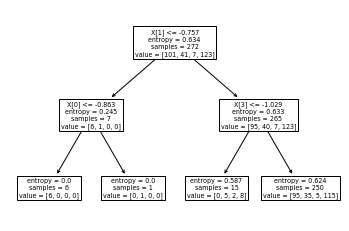

In [30]:
tree.plot_tree(classifier)

In [44]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(classifier, open(filename, 'wb'))

# Discussion:
After the machine learning , I obtain an estimator with a f1 accuracy of 0,53. This estimator is not very high, but we can say that he his better than random. As there is 4 option for the happiness score (Not Happy, Happy-, Happy+, Very Happy), randomly guessing the happiness score would result in an accuracy of 0,25.

## Data
In order to estimate the hapiness of the communities, I chose to take count the number of:

    -Restaurant
    -Taxi
    -Sport facilities
    -Transportation facilities
    -Subway station
    -Shopping
in a circle of 200 meters around the localisation of the community. I found the number of 200 meters by trying different (50,100,200,400). The previous were too "small", and some communities had no informations. 400 meters is too big, and the results were less good.
I then scaled the datas, so they are all on the same scall to use them efficiently later.

## Happiness
From the study given, people rate their community environment on 3 criteria : 

    -Clean (1 to 4, 4 is best)
    -Smell (Binary, 0 is best)
    -Noise (Binary, 0 is best)
Tos simplify the treatment and the machine learning, I decided to compute a "score of happiness" from this criteria. I then came up with this formula :

    ((Clean-1)/3-Smell*0,2-Noise*0,2+0,4)/1,4
    
    (Clean-1)/3 : This formula put back the result from clean between 0 and 1, with 4 possible values: 0,1/3,2/3,1
    -Smell*0,2-Noise*0,2 : The smell and noise score are "negative", as 1 is the worst. I then decided of the 0,2 factor, to balance them regarding the clean score. If the factor is too high, they have too much weight, and a 1 in one of them descrease extremely the happiness. If the factor is too low, they don't have any influence.
    +0,4)/1,4 : As I put 2 negative factors of 0,2 on binary, the worst score could be -0,4 and the best 1. I put this to get back the score between 0 and 1.
    
I then decided to categorize this happiness score, in 4 category : 

Not Happy (value<0,26), Happy-(0,26<=value<0,51), Happy+ (0,51<=value<0,76), Very Happy (value>=0,76).

I did this so the machine learning is more efficient, with only 4 different possibilities.

## Machine Learning
After testing different models, I found out that for our case (small amount of data, finding discrete datas etc.), the decision Tree abtained the best results.
Using the gridsearch, I found the best depth parameter, and I wes then capable to train a model and test it.
After a test on 100 datas, I obtain an accuracy score of 0.53, so we can say that this model is better than random (who would have an accuracy of 0.25, as there is 4 category).

## Conclusion
The results are acceptable, as it is better than random, but they could maybe be better if we had more datas for the learning part(only around 400 datas on TARGET). 

This model allows to predict, with an accuracy of aroud 53%, "at which point" people will be happy or not. It's not a lot, but it give some informations, if people wonder in which neighborhood to live, for exemple. As shown by the decision tree, we can say that the more important datas are : shopping, then restaurant and transportation.